# Introduction

In this lab we will learn how to use a digital LLRF system as a vector network analyzer. We will also leverage the experience from previous lab exercise on ADC, DAC and DDS, and the 20 MHz crystal characterizations.

We will operate the feedback loops using the 20 MHz crystal as a resonator.

## Firmware details

![feedback_firmware](uspas_llrf-feedback.png)

| Frequency    | Derivation  | Value  | Unit |
|--------------|-------------|--------|------|
| f_MO         |             | 480    | MHz  |
| f_IF         | f_MO/24     | 20     | MHz  |
| f_LO         | f_MO - f_IF | 460    | MHz  |
| f_CLK        | f_LO / 4    | 115    | MHz  |
| f_IF / f_CLK |             | 4 / 23 |      |

## Hardware setup

![hardware](uspas_llrf-feedback_hw.png)

Connect the system as shown in the diagram, so we have both direct loop back on `ADC1` and with 20 MHz crystal in the system on `ADC5`.
The firmware has identical `DAC Q1` and `DAC Q2` output, as we previously measured on the DAC characterization lab.

## Firmware and software setup
* Configure FPGA chassis using the provided `marble_zest_top_uspas.bit`;
* Start EPICS IOC on the connected laptop computer;
* Run Phoebus GUI on the connected laptop computer;

## EPICS PVs:

Note: all raw registers like `reg_*` have separate write and read-back PVs.

To write a raw register such as `USPAS:LLRF:reg_amp_loop_enable`:
```bash
caput USPAS:LLRF:reg_amp_loop_enable 0
```
To read it back, read the PV with `_RBV` as suffix.
```bash
caget USPAS:LLRF:reg_amp_loop_enable_RBV
```

#### Waveform:
* `USPAS:LLRF:ACQ_SAMP_PERIOD`
: Waveform sampling period
* `USPAS:LLRF:ACQ_DECIM`
: Waveform decimation value

#### Amplitude loop:
* `USPAS:LLRF:Loop:AmpSetp`
: Holds amplitude loop setpoint value, calibrated with waveform
* `USPAS:LLRF:reg_amp_setpoint`
: Holds amplitude loop setpoint value, raw
* `USPAS:LLRF:reg_amp_loop_enable`
: Enables amplitude loop
* `USPAS:LLRF:reg_amp_loop_reset`
: Resets amplitude loop
* `USPAS:LLRF:reg_Kp_amp`
: Amplitude loop proportional gain
* `USPAS:LLRF:reg_Ki_amp`
: Amplitude loop integral gain

#### Phase loop:
* `USPAS:LLRF:Loop:PhsSetp`
: Holds phase loop setpoint value, calibrated with waveform
* `USPAS:LLRF:reg_phs_setpoint`
: Holds phase loop setpoint value, raw
* `USPAS:LLRF:reg_phs_loop_enable`
: Enables phase loop
* `USPAS:LLRF:reg_phs_loop_reset`
: Resets phase loop
* `USPAS:LLRF:reg_Kp_phs`
: Phase loop proportional gain
* `USPAS:LLRF:reg_Ki_phs`
: Phase loop integral gain

# Exercises

## Run EPICS Phoebus interface

See `README.md` for docker command:
```bash
xhost local:root
docker run --rm -it --name phoebus_alsu --network="host" -e DISPLAY=${DISPLAY} -v /tmp/.X11-unix:/tmp/.X11-unix -v $HOME/.Xauthority:/root/.Xauthority lerwys/epics_phoebus_alsu
```


## Run pulse mode
* Set Amp Loop setpoint to 30000.
* Toggle "Pulse Mode" button to "ON".
* Adjust pulse width to 60000.
* Set waveform `Decimation` to 50.

The pulse length is 23 * 60000 / 115e6 = 12.0 µs.
The CIC filter before the waveform will average 23 * Decimation samples, so the waveform sample interval is 1/115e6 * 50 * 23 = 10.0 µs. This will give us enough length of waveforms to capture about 32 ms.

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import signal
import pandas as pd
import numpy as np
from epics import PV, caget, caput

import os
os.environ['EPICS_CA_ADDR_LIST'] = 'localhost'
os.environ['EPICS_CA_AUTO_ADDR_LIST'] = 'NO'

plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.which'] = "both"
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['font.size'] = 8

In [8]:
caput('USPAS:LLRF:Loop:AmpSetp', 30000)
caput('USPAS:LLRF:reg_pulse_mode', 1)
caput('USPAS:LLRF:reg_pulse_high_len', 60000)
caput('USPAS:LLRF:ACQ_DECIM', 50)

1


The ADC5 waveform will show the step response of the crystal.
It is expected to have a result like the following screenshot.

![pulse1](pulse1.png)

Explain the reason of ringing of the ADC5 amplitude and phase waveforms.
Explain the spirals in IQ waveform plot.


## Find cavity detune through falling edge analysis

In [9]:

fs = 1e6 / PV('USPAS:LLRF:ACQ_SAMP_PERIOD').value
pv_twf = PV('USPAS:LLRF:CavCel:TWF')
pv_awf = PV('USPAS:LLRF:CavCel:AWF')
pv_pwf = PV('USPAS:LLRF:CavCel:PWF')
pv_iwf = PV('USPAS:LLRF:CavCel:IWF')
pv_qwf = PV('USPAS:LLRF:CavCel:QWF')

df = pd.DataFrame({
    'T [µs]': pv_twf.value,
    'amp': pv_awf.value,
    'phs': pv_pwf.value,
    'i': pv_iwf.value, 'q': pv_qwf.value})
df.set_index('T [µs]');

<AxesSubplot: >

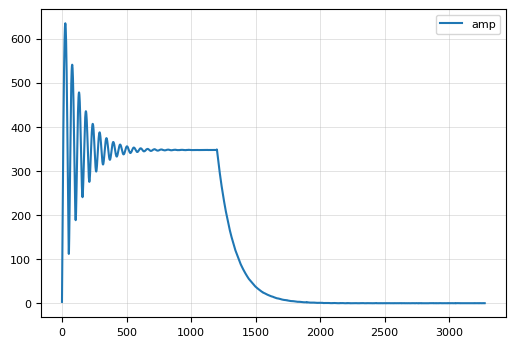

In [10]:
df[['amp']].plot()

<AxesSubplot: >

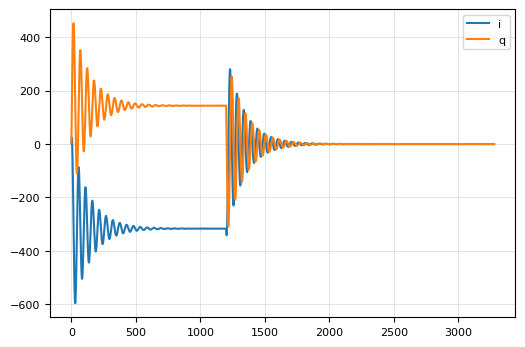

In [11]:
df[['i', 'q']].plot()

<AxesSubplot: xlabel='i'>

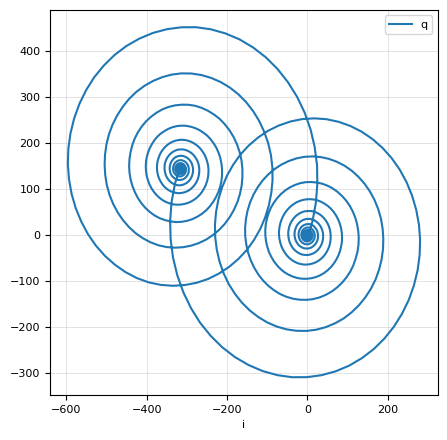

In [12]:
df[['i', 'q']].plot(x='i', figsize=(5,5))

## Extract detune frequency from falling edge

## Measure the crystal bandwidth.
Compare the results to the one you measured on the first day.

## Adjust LLRF LO DDS to *tune* crystal
![pulse2](pulse2.png)

## Close amplitude and phase loop

1. Disable pulse mode
2. Adjust amplitude setpoint to 2000
3. Set both loops Ki, Kp gain to 1
4. Reset both loops

Increase integral and proportional gain and observe loop stability.